<a href="https://colab.research.google.com/github/Esantomi/digital-humanities/blob/main/%EB%B0%B0%ED%8F%AC_%EB%85%BC%EB%AC%B8_%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9C%BC%EB%A1%9C_%EB%B6%88%EA%B2%BD_%EC%9D%BD%EA%B8%B0_Word2Vec%EB%B6%88%EA%B2%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CBETA 불경 전체

- 작업프로세스

1) CBETA 데이터 확보


2) CBETA 데이터 MSSQL 입력


3) CBETA 데이터 중에서 "Body" 만 사용


```
create view cbeta as 
WITH XMLNAMESPACES ('http://www.tei-c.org/ns/1.0' as ns)  
select XmlCol.value('(//ns:TEI/@xml:id)[1]', 'nvarchar(max)') as id, 
XmlCol.value('(//ns:body)[1]', 'nvarchar(max)') as text from t
```




4) 출력 텍스트 정제

(1) 줄바꿈 제거:  \n  --> ""

(2) 마침표를 줄바꿈으로 대체 : 



5) 데이터 가져오기 - 구글드라이브 연계


6) 데이터 분석


7) 데이터 시각화

  

## 기본 환경 설정

In [ ]:
# gensim을 설치합니다. (Gensim은 Python 기반의 Text mining library이며, 토픽 모델링, word2vec도 지원합니다.)
!pip install -U gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.7.2)


In [ ]:
# NLTK를 설치합니다. (자연어 처리를 위해 광범위하게 쓰이는 Python library입니다.)
!pip install nltk

### 구글드라이브 링크를 통한 DATA Import

In [ ]:
# 구글 드라이브 연결을 위한 기본 세팅
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 3.4MB/s 


In [ ]:
# 문서 ID로 실제 파일 불러오는 법

##https://drive.google.com/open?id=1L5UHGe1V2NxphCJkeucDGJHesVBytua5
rawdata_downloaded = drive.CreateFile({'id': '1L5UHGe1V2NxphCJkeucDGJHesVBytua5'})
rawdata_downloaded.GetContentFile('cbetatest.csv')

In [ ]:
import sys
import csv
csv.field_size_limit(sys.maxsize)


131072

## Word2Vec

In [ ]:
import pandas as pd

pd.set_option('max_colwidth',500)

# 파일을 DataFrame으로 전환
rawdataCbeta = pd.read_csv('cbetatest.csv', sep='\t', encoding='utf-8', dtype=str, engine='python')

In [ ]:
rawdataCbeta.columns=["iii","text"]

In [ ]:
rawtextCbeta = str(list(rawdataCbeta['text']))

In [ ]:
## 해당 부분은 메모리 부족으로 colab에서의 실행에 문제 있음

# stopwords = '，|：|[|]|。|？|「|」|！|,|\'|；|、|『|』|《|》|而|何|乎|乃|其|且|若|所|為|焉|以|因|於|與|于|也|則|者|之|不|自|無|可|是|已|此|的|兮|曰|亦|矣'
stopwords = '，|,|：|[|]|。|？|「|」|！|,|\'|；|、|『|』|《|》|'

states = [[i.strip( ) for i in rawt if i not in stopwords] for rawt in rawtextCbeta]
states

In [ ]:
states_list = list(filter(None, rawtextCbeta.split(' ')))

In [ ]:
# training 모델 훈련
from gensim.models import word2vec
wv_model_cbeta = word2vec.Word2Vec(states_list, size=100, window=5, min_count=5, iter=5, sg=1)
wv_model_cbeta.init_sims(replace=True)
wv_model_cbeta.save('cbeta_word2vec_e.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# training 모델 훈련
from gensim.models import word2vec
from gensim.models import FastText
wv_model_cbeta = FastText(states_list, size=100, window=5, min_count=100, workers=4, iter=10, sg=1)
## size=차원의 숫자(올라갈수록 상세히 하지만 느림) 100
## window=주변을 보는 범위(앞뒤 5) 
## min_count=최소 출현 빈도 100
## workers=사용하는 CPU 코어 숫자
## iter = 반복횟수 10
## sg= CBOW=0 / Skip-Gram=1

wv_model_cbeta.init_sims(replace=True)
wv_model_cbeta.save('cbeta_word2vec_e.model')

In [ ]:
model = word2vec.Word2Vec.load('cbeta_word2vec_e.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
## 입력 단어 확인용
##len(model.wv.vocab.keys())
##list(wv_model_cbeta.wv.index2word)

In [ ]:
print(model['心']) 

[ 0.07339495 -0.09707004  0.01506011  0.12479733  0.04507668 -0.17066783
  0.03295533 -0.08056071  0.07477152 -0.05345425 -0.0605623   0.07720254
  0.10299294 -0.02568092  0.0642975  -0.03635741 -0.02884382 -0.07185764
 -0.15551507  0.04293279  0.04375871  0.16647649 -0.12938337 -0.10326705
 -0.01800406  0.12342936  0.15525247  0.1101636   0.0306557  -0.03178752
  0.01185309 -0.1034078  -0.11130061 -0.02538653  0.02004731 -0.00930282
 -0.05903332 -0.01967241  0.19997513  0.04802288  0.0185786   0.09029248
  0.01111582 -0.08626959 -0.02687947 -0.01528981 -0.00491941  0.01500235
  0.02534887 -0.05473835  0.18176515  0.12012309 -0.05831908 -0.22742857
 -0.03963643  0.0750051  -0.00282875 -0.12192435  0.14720279  0.03315945
  0.10601064  0.1363469   0.13113333 -0.03882471 -0.03847517 -0.15865241
  0.06489605  0.04649458 -0.19984937 -0.03341489  0.0854272  -0.18757646
  0.07971082 -0.15326853  0.09665559 -0.30210984  0.11221164 -0.03235089
  0.01758671 -0.0113764   0.07328238  0.16056658 -0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
model.similar_by_word('心')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('性', 0.5667176246643066),
 ('念', 0.564367413520813),
 ('不', 0.5502288341522217),
 ('是', 0.548933744430542),
 ('體', 0.5286092758178711),
 ('自', 0.5277736783027649),
 ('即', 0.5233985185623169),
 ('唯', 0.5200825929641724),
 ('發', 0.5181437730789185),
 ('惱', 0.5083914995193481)]

In [ ]:
model.similar_by_word('佛')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('仏', 0.5703094601631165),
 ('聖', 0.5647306442260742),
 ('薩', 0.5303727984428406),
 ('法', 0.48981648683547974),
 ('來', 0.4895453155040741),
 ('尊', 0.4824603199958801),
 ('此', 0.47422143816947937),
 ('是', 0.46959495544433594),
 ('菩', 0.4673008918762207),
 ('，', 0.4662948250770569)]

In [ ]:
# test 결과보기
print(wv_model_cbeta.most_similar('心', topn=50))

[('性', 0.5667176246643066), ('念', 0.5643673539161682), ('不', 0.5502288341522217), ('是', 0.548933744430542), ('體', 0.5286092758178711), ('自', 0.5277736186981201), ('即', 0.5233985185623169), ('唯', 0.5200825929641724), ('發', 0.5181437730789185), ('惱', 0.5083914995193481), ('」', 0.5075925588607788), ('緣', 0.4993239641189575), ('無', 0.49107030034065247), ('意', 0.49025392532348633), ('起', 0.4889511466026306), ('我', 0.4872244596481323), ('生', 0.48688310384750366), ('真', 0.4808192849159241), ('能', 0.48009103536605835), ('得', 0.4790881276130676), ('切', 0.4751066565513611), ('信', 0.4695656895637512), ('㊁', 0.46916425228118896), ('煩', 0.46554842591285706), ('非', 0.4649414122104645), ('故', 0.4637109935283661), ('她', 0.4619259834289551), ('情', 0.46003156900405884), ('所', 0.45870789885520935), ('薩', 0.4575563669204712), ('他', 0.4559216797351837), ('證', 0.4523168206214905), ('相', 0.4515673518180847), ('法', 0.44926926493644714), ('實', 0.4466504156589508), ('您', 0.4458795189857483), ('別', 0.44561466574

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
# test 결과보기
print(wv_model_cbeta.most_similar('佛', topn=50))

[('仏', 0.5703094601631165), ('聖', 0.5647306442260742), ('薩', 0.5303727984428406), ('法', 0.48981648683547974), ('來', 0.4895453155040741), ('尊', 0.4824603199958801), ('此', 0.474221408367157), ('是', 0.46959495544433594), ('菩', 0.4673008918762207), ('，', 0.4662948250770569), ('師', 0.4656856954097748), ('教', 0.4630179703235626), ('以', 0.4569056034088135), ('大', 0.4558424949645996), ('於', 0.4552474021911621), ('說', 0.4493514895439148), ('我', 0.4474824368953705), ('世', 0.4449007511138916), ('稱', 0.44429540634155273), ('就', 0.4441550374031067), ('彌', 0.4384750723838806), ('即', 0.43780195713043213), ('王', 0.4354288578033447), ('所', 0.4348675608634949), ('奉', 0.4346688687801361), ('閦', 0.42601633071899414), ('弟', 0.4227617383003235), ('表', 0.42193418741226196), ('」', 0.4210301637649536), ('已', 0.42010653018951416), ('在', 0.41991567611694336), ('方', 0.41961216926574707), ('時', 0.4186135530471802), ('者', 0.41810140013694763), ('行', 0.4160391092300415), ('←', 0.4158012866973877), ('一', 0.4107530713

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
print(wv_model_cbeta.most_similar(positive='心', negative='性', topn=50))

[('衷', 0.31795984506607056), ('懇', 0.308720201253891), ('蹕', 0.30515021085739136), ('署', 0.2951500415802002), ('帷', 0.29505854845046997), ('薩', 0.290310263633728), ('斾', 0.28978461027145386), ('撕', 0.28695592284202576), ('祈', 0.2835286855697632), ('闈', 0.2747423052787781), ('扳', 0.26212090253829956), ('眴', 0.2608742117881775), ('轡', 0.25984373688697815), ('慇', 0.2577073574066162), ('閈', 0.2567213773727417), ('緊', 0.2561984956264496), ('發', 0.25228023529052734), ('寢', 0.2510291337966919), ('勞', 0.25027817487716675), ('勿', 0.2496698796749115), ('幃', 0.2484658807516098), ('𠇲', 0.2465241700410843), ('虔', 0.24642017483711243), ('忻', 0.2463533878326416), ('嚀', 0.24544179439544678), ('惓', 0.24475140869617462), ('蹔', 0.2447330355644226), ('蹌', 0.24427473545074463), ('留', 0.2439510077238083), ('她', 0.24328278005123138), ('士', 0.2431696653366089), ('怏', 0.24297590553760529), ('壼', 0.24252259731292725), ('帆', 0.24166515469551086), ('叮', 0.24110057950019836), ('吝', 0.24080345034599304), ('菩', 0.24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
print(wv_model_cbeta.most_similar(positive=['心','不','起'], topn=100))

In [ ]:
print(wv_model_cbeta.most_similar(positive=['念','不','起'], topn=100))

## 시각화


### http://projector.tensorflow.org/


## Publish 용 링크
http://projector.tensorflow.org/?config=https://gist.githubusercontent.com/ddokbaro/1d57b83de08d791e2905e9726fe1c215/raw/a6178fe978bdacd12d81da49d92eecb40e4b572a/test.json


## Publish 참조 페이지
https://medium.com/@aakashchotrani/visualizing-your-own-word-embeddings-using-tensorflow-688b3a7750ee


In [ ]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = 'cbeta_word2vec_e.model'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
tsne = TSNE(n_components=3)

In [ ]:
tsne

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=3, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)

In [ ]:
X

array([[-0.08660284,  0.1729583 ,  0.03756157, ...,  0.00723607,
        -0.3011662 , -0.07153665],
       [-0.07922973, -0.07207758,  0.15834507, ...,  0.02019738,
        -0.24422796, -0.00082793],
       [-0.07968011, -0.01857368, -0.07333653, ..., -0.00133099,
        -0.13802563, -0.05283356],
       ...,
       [-0.04144316,  0.17818236, -0.1296622 , ..., -0.17600887,
        -0.19803037, -0.17568418],
       [-0.07930433,  0.05663193, -0.17288785, ...,  0.0196688 ,
        -0.13074544, -0.00678732],
       [-0.06607528,  0.05579002, -0.16450399, ...,  0.02638538,
        -0.135157  , -0.02632539]], dtype=float32)

In [ ]:
X_tsne = tsne.fit_transform(X)
# X_tsne = tsne.fit_transform(X)

In [ ]:
X_tsne

array([[-7.884581  ,  7.66709   , 45.710796  ],
       [-8.49023   ,  4.981042  , 35.474834  ],
       [ 0.56256974, -1.2985715 , 32.394028  ],
       ...,
       [13.824739  ,  8.116338  ,  4.9844403 ],
       [-2.4798245 , 12.263617  , 38.253998  ],
       [-2.4871638 , 12.2435    , 38.2956    ]], dtype=float32)

In [ ]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y', 'z'])
df.shape

In [ ]:
df

,x,y
[,4.041784,-6.641166
',-2.192384,0.592682
序,-0.524974,3.416006
音,-6.634773,-2.449347
義,-1.947444,2.324216
經,-1.621962,3.200342
天,1.364905,0.304573
冊,3.232506,0.790347
測,-1.663458,-3.270848
革,5.799370,-4.054384


In [ ]:
df.to_csv('fin_fo3.tsv', encoding='utf-8')

### 전체Top1000

In [ ]:
# your current directory 
!pwd

## 한국어: !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip"
## 번자체한자: !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip"

!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip"

# remove files in zip file if they exist
!rm LICENSE_OFL.txt README *.otf 

# unzip downloaded files
## 한국어: !unzip NotoSansCJKkr-hinted.zip
## 번체자한자: !unzip NotoSerifCJKtc-hinted.zip

!unzip NotoSerifCJKtc-hinted.zip

# move font files to 'fonts/truetype' directory
## 한국어: !mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/
## 번체자한자: !mv NotoSerifCJKtc-Medium.otf /usr/share/fonts/truetype/

!mv NotoSerifCJKtc-Medium.otf /usr/share/fonts/truetype/

/content
--2019-07-01 10:17:59--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c01::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130464138 (124M) [application/zip]
Saving to: ‘NotoSerifCJKtc-hinted.zip.1’

NotoSerifCJKtc-hint 100%[===================>] 124.42M   167MB/s    in 0.7s    

2019-07-01 10:18:00 (167 MB/s) - ‘NotoSerifCJKtc-hinted.zip.1’ saved [130464138/130464138]

Archive:  NotoSerifCJKtc-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSerifCJKtc-Black.otf  
  inflating: NotoSerifCJKtc-Bold.otf  
  inflating: NotoSerifCJKtc-ExtraLight.otf  
  inflating: NotoSerifCJKtc-Light.otf  
  inflating: NotoSerifCJKtc-Medium.otf  
  inflating: NotoSerifCJKtc-Regular.otf  
  inf

In [ ]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = 'cbeta_word2vec_e.model'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


14710
[-0.08660284  0.1729583   0.03756157 -0.12097019 -0.11921705 -0.03769559
  0.06750689  0.20477678  0.00427028 -0.06508055]


In [ ]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [ ]:
df.head(10)

,x,y
[,-5.680853,-2.687645
',4.169378,0.359761
序,2.115889,5.389083
音,3.480742,-4.172779
義,3.980055,4.053023
經,3.584332,5.156906
天,0.523648,-0.444902
冊,0.725951,6.678225
測,0.396928,2.760991
革,-6.212959,-1.025108


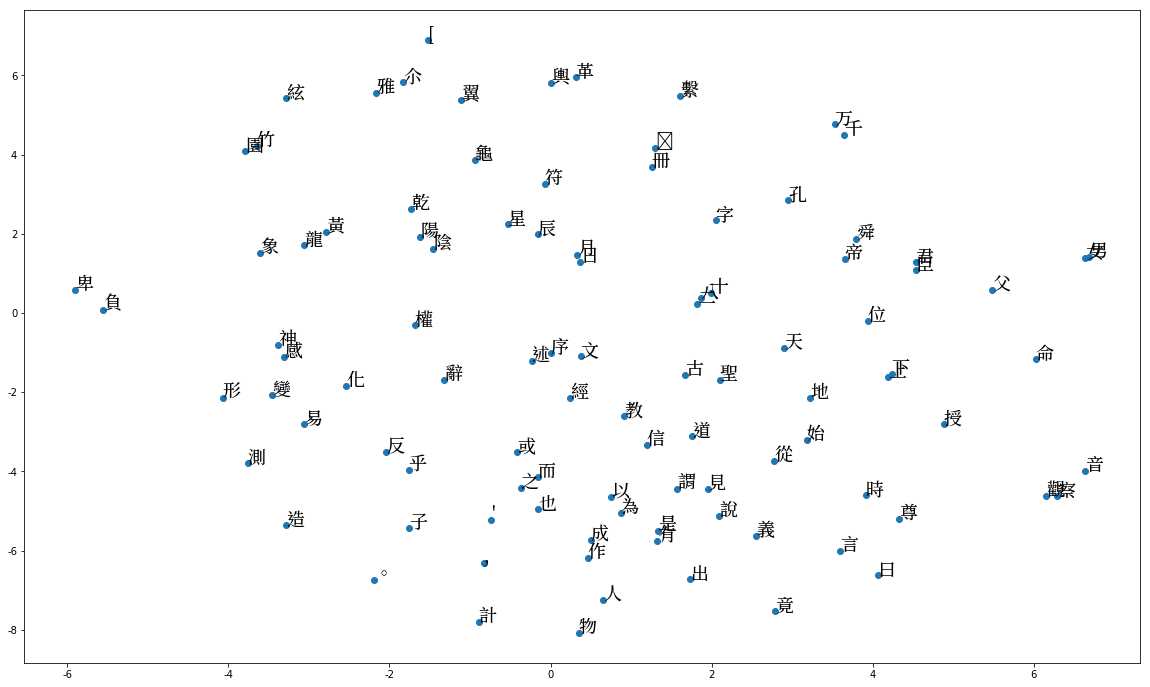

In [ ]:
import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/NotoSerifCJKtc-Medium.otf'
fontprop = fm.FontProperties(fname=path, size=18)

fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontproperties=fontprop)
plt.show()

In [ ]:
import pandas as pd

pd.set_option('max_colwidth',500)

# 파일을 DataFrame으로 전환
rawdata2 = pd.read_csv('般舟三昧經_1자.txt', sep='\t', encoding='utf-8', dtype=str, engine='python')

In [ ]:
rawdata2

,Tid,WordSeg
0,1,不 著 心 如 虛 空 無 所 止 如 金 剛 鑽 無 所 不 入 安 如 須 彌 山 不 可 動 如 門 閫 正 住 堅
1,2,心 軟 如 鵠 毛 無 有 麁 爽 身 無 所 慕 樂 於 山 川 如 野 獸
2,3,若 沙 門 道 人 多 所 教 授 皆 護 視 若 有 輕 嬈 者 終 無 瞋 恚 心 一 切 諸 魔 不 能 動
3,4,莊 嚴 諸 國 土 於 戒 中 清 淨 阿 羅 漢 辟 支 佛 心 所 作 為 者 皆 究 竟
4,5,心 不 可 計 一 切 諸 剎 心 不 著 無 所 適 念 出 於 諸 佛 剎 無 所 復 罣 礙
5,6,心 一 反 念 佛 悉 在 前 立 一 切 適 不 復 願 適 無 所 生 處 十 方 不 可 計 佛 剎 悉 見 聞 諸 佛 所 說 經 一 一 佛 比 丘 僧 悉 見
6,7,用 是 故 極 大 慈 哀 一 切 人 民 皆 於 等 心 隨 時 欲 見 佛 即 見 佛
7,8,所 願 極 廣 大 甚 深 之 行 常 念 佛 智 慧 悉 持 經 戒 悉 具 足 佛 種 聖 心 如 金 剛 悉 知 世 間 人 民 心 所 念 悉 在 諸 佛 前
8,9,飯 知 足 不 貪 衣 不 惜 壽 命 子 身 避 親 屬 離 鄉 里 習 等 意 得 悲 意 心 護 行 棄 蓋 習 禪
9,10,其 有 比 丘 比 丘 尼 優 婆 塞 優 婆 夷 持 戒 完 具 獨 一 處 止 心 念 西 方 阿 彌 陀 佛 今 現 在


In [ ]:
rawtext2 = str(list(rawdata2['WordSeg ']))

In [ ]:
states_list2 = list(filter(None, rawtext2.split(' ')))

In [ ]:
states_list2

["['不著心如虛空無所止如金剛鑽無所不入安如須彌山不可動如門閫正住堅',",
 "'心軟如鵠毛無有麁爽身無所慕樂於山川如野獸',",
 "'若沙門道人多所教授皆護視若有輕嬈者終無瞋恚心一切諸魔不能動',",
 "'莊嚴諸國土於戒中清淨阿羅漢辟支佛心所作為者皆究竟',",
 "'心不可計一切諸剎心不著無所適念出於諸佛剎無所復罣礙',",
 "'心一反念佛悉在前立一切適不復願適無所生處十方不可計佛剎悉見聞諸佛所說經一一佛比丘僧悉見',",
 "'用是故極大慈哀一切人民皆於等心隨時欲見佛即見佛',",
 "'所願極廣大甚深之行常念佛智慧悉持經戒悉具足佛種聖心如金剛悉知世間人民心所念悉在諸佛前',",
 "'飯知足不貪衣不惜壽命子身避親屬離鄉里習等意得悲意心護行棄蓋習禪',",
 "'其有比丘比丘尼優婆塞優婆夷持戒完具獨一處止心念西方阿彌陀佛今現在',",
 "'菩薩若沙門白衣所聞西方阿彌陀佛剎當念彼方佛不得缺戒一心念——若一晝夜若七日七夜——過七日以後見阿彌陀佛於覺不見於夢中見之',",
 "'菩薩心當作是念',",
 "'時諸佛國界名大山須彌山其有幽冥之處悉為開闢目亦不蔽心亦不礙',",
 "'我所念即見心作佛心自見心是佛心是怛薩阿竭心是我身心見佛心不自知心心不自見心心有想為癡心無想是泥洹',",
 "'心者不知心有心不見心心起想則癡無想是泥洹',",
 "'當供養於佛花香擣香飯食具足當持善意用是故三昧離不遠持常鼓樂倡伎樂於佛心常當娛樂',",
 "'瞋恚不生常行於慈心常行悲哀等心無所憎惡今得是三昧不久',",
 "'如是等菩薩當慈心常樂於善師所視師當如佛悉具足承事',",
 "'是菩薩欲得今現在諸佛悉在前立三昧布施當具足持戒如是忍辱精進一心智慧度脫智慧身悉具足',",
 "'如是菩薩得三昧以常見不可計佛所信常有哀心譬如渴者欲得飲',",
 "'若持戒堅者常正心恭敬於經我用是故為是人說耳',",
 "'我當從心得從身得',",
 "'佛亦不用心得亦不用身得亦不用心得佛亦不用色得佛',",
 "'心者佛無心色者佛無色',",
 "'不用是心色得阿耨多羅三藐三菩提',",
 "'菩薩見佛以菩薩心念無所著',",
 "'如新磨鏡盛油器女人莊飾自照形於中起生婬欲心放逸恣態甚迷荒',",
 "'諸佛從心解得道心者清淨明無垢五道鮮潔不受色有解是者成大道',",
 "'一切諸法無色

In [ ]:
# training 모델 훈련
from gensim.models import word2vec
wv_model_02 = word2vec.Word2Vec(states_list2)
wv_model_02.init_sims(replace=True)
wv_model_02.save('02_word2vec_e.model')

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [ ]:
# training 모델 훈련
from gensim.models import word2vec
from gensim.models import FastText
wv_model_02 = FastText(states_list2, size=300, window=10, min_count=0, workers=1, iter=10, sg=1)
## size=차원의 숫자(올라갈수록 상세히 하지만 느림) 100
## window=주변을 보는 범위(앞뒤 5) 
## min_count=최소 출현 빈도 100
## workers=사용하는 CPU 코어 숫자
## iter = 반복횟수 10
## sg= CBOW=0 / Skip-Gram=1

wv_model_02.init_sims(replace=True)
wv_model_02.save('02_word2vec_e.model')

In [ ]:
model = word2vec.Word2Vec.load('02_word2vec_e.model')

len(model.wv.vocab.keys())

list(wv_model_02.wv.index2word)


["'",
 '心',
 '不',
 ',',
 '是',
 '無',
 '佛',
 '得',
 '者',
 '所',
 '三',
 '昧',
 '有',
 '行',
 '常',
 '當',
 '如',
 '見',
 '一',
 '法',
 '於',
 '人',
 '諸',
 '其',
 '念',
 '持',
 '慧',
 '樂',
 '道',
 '悉',
 '時',
 '十',
 '用',
 '事',
 '中',
 '智',
 '菩',
 '薩',
 '經',
 '知',
 '意',
 '若',
 '在',
 '等',
 '離',
 '清',
 '淨',
 '大',
 '欲',
 '我',
 '然',
 '學',
 '身',
 '終',
 '能',
 '戒',
 '復',
 '世',
 '貪',
 '後',
 '亦',
 '想',
 '遠',
 '此',
 '奉',
 '著',
 '切',
 '為',
 '方',
 '聞',
 '說',
 '具',
 '足',
 '棄',
 '日',
 '以',
 '施',
 '色',
 '解',
 '及',
 '喜',
 '立',
 '比',
 '丘',
 '即',
 '之',
 '自',
 '起',
 '惡',
 '精',
 '進',
 '從',
 '五',
 '受',
 '尊',
 '除',
 '誦',
 '彌',
 '可',
 '阿',
 '礙',
 '前',
 '生',
 '慈',
 '陀',
 '—',
 '善',
 '師',
 '忍',
 '去',
 '求',
 '歡',
 '逮',
 '數',
 '便',
 '空',
 '止',
 '山',
 '正',
 '教',
 '皆',
 '護',
 '恚',
 '羅',
 '計',
 '故',
 '民',
 '子',
 '今',
 '現',
 '七',
 '癡',
 '供',
 '婬',
 '捨',
 '天',
 '與',
 '八',
 '踊',
 '上',
 '和',
 '諷',
 '瞋',
 '魔',
 '剎',
 '罣',
 '處',
 '極',
 '哀',
 '過',
 '泥',
 '洹',
 '養',
 '布',
 '度',
 '脫',
 '敬',
 '覩',
 '懈',
 '聽',
 '莫',
 '慢',
 '諂',
 '懷',
 '神',
 '而',
 '百'

In [ ]:
# test 결과보기
print(wv_model_02.most_similar('心', topn=10))

[('況', 0.2083427906036377), ('於', 0.1991506814956665), ('度', 0.18643586337566376), ('學', 0.17083407938480377), ('磨', 0.12805111706256866), ('鼓', 0.12471196055412292), ('既', 0.12292696535587311), ('受', 0.12119513005018234), ('提', 0.12052466720342636), ('識', 0.11711975932121277)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
# test 결과보기
print(wv_model_02.most_similar('佛', topn=10))

[('悲', 0.15691274404525757), ('空', 0.14146867394447327), ('戲', 0.13255998492240906), ('習', 0.12952591478824615), ('見', 0.12706300616264343), ('悕', 0.12512962520122528), ('一', 0.11869074404239655), ('弊', 0.11761167645454407), ('避', 0.11474300920963287), ('生', 0.10797125101089478)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '01_word2vec_e.model'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


142
[ 0.05214022  0.16555789  0.12805705  0.0334642  -0.07596427  0.12540793
 -0.01053617 -0.03192265 -0.10542073  0.06165267]


In [ ]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [ ]:
path = '/usr/share/fonts/truetype/NotoSerifCJKtc-Medium.otf'
fontprop = fm.FontProperties(fname=path, size=18)

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontproperties=fontprop)
plt.show()

# Word2Vec - 개별 불경



## 기본 환경 설정

In [ ]:
# gensim을 설치합니다. (Gensim은 Python 기반의 Text mining library이며, 토픽 모델링, word2vec도 지원합니다.)
!pip install -U gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.7.2)


In [ ]:
# NLTK를 설치합니다. (자연어 처리를 위해 광범위하게 쓰이는 Python library입니다.)
!pip install nltk

## 불경01 - 般舟三昧經(CBETA API 1.2.7 적용)

### 기본데이터셋 구축

In [ ]:
import pandas as pd

# 파일을 DataFrame으로 전환
rawdata = pd.read_csv('般舟三昧經.txt', sep='\t', encoding='utf-8', dtype=str, engine='python')

In [ ]:
rawdata

,Tid,WordSeg
0,1,不 著 心 如 虛空 無 所 止 如 金剛 鑽 無 所 不 入 安 如 須彌山 不 可 動...
1,2,心 軟 如 鵠 毛 無有 麁爽 身 無 所 慕樂 於 山川 如 野 獸
2,3,若 沙門 道人 多 所 教授 皆 護視 若 有 輕嬈 者 終 無 瞋恚 心 一切 諸 ...
3,4,莊嚴 諸 國土 於 戒 中 清淨 阿羅漢 辟支佛 心 所 作為 者 皆 究竟
4,5,心 不 可 計 一切 諸 剎 心 不 著 無 所 適 念 出 於 諸 佛剎 無 所 ...
5,6,心 一 反 念 佛 悉 在 前 立 一切 適 不復 願 適 無 所 生 處 十方 不 ...
6,7,用 是 故 極 大 慈哀 一切 人民 皆 於 等 心 隨 時 欲 見 佛 即 見 佛
7,8,所 願 極 廣大 甚 深 之 行 常 念 佛 智慧 悉 持 經戒 悉 具足 佛種 聖心...
8,9,飯 知足 不 貪 衣 不 惜 壽命 子 身 避 親屬 離 鄉里 習 等 意 得 悲意 ...
9,10,其 有 比丘 比丘尼 優婆塞 優婆夷 持戒 完具 獨 一處 止 心念 西方 阿彌陀 ...


In [ ]:
rawtext = str(list(rawdata['WordSeg']))

In [ ]:
rawtext

"[' 不 著 心 如 虛空 無 所 止 如 金剛 鑽 無 所 不 入 安 如 須彌山 不 可 動 如 門閫 正 住 堅 ', ' 心 軟 如 鵠 毛  無有 麁爽 身 無 所 慕樂  於 山川 如 野 獸 ', ' 若 沙門 道人 多 所 教授 皆 護視  若 有 輕嬈 者 終 無 瞋恚 心  一切 諸 魔 不 能 動 ', ' 莊嚴 諸 國土  於 戒 中 清淨 阿羅漢 辟支佛 心  所 作為 者 皆 究竟 ', ' 心 不 可 計  一切 諸 剎 心 不 著  無 所 適 念 出 於 諸 佛剎  無 所 復 罣礙 ', ' 心 一 反 念  佛 悉 在 前 立  一切 適 不復 願 適 無 所 生 處 十方 不 可 計 佛剎 悉 見  聞 諸 佛 所 說 經 一一 佛 比丘 僧 悉 見 ', ' 用 是 故 極 大 慈哀  一切 人民 皆 於 等 心  隨 時 欲 見 佛 即 見 佛 ', ' 所 願 極 廣大 甚 深 之 行  常 念 佛 智慧  悉 持 經戒 悉 具足 佛種 聖心 如 金剛 悉 知 世間 人民 心 所 念 悉 在 諸 佛 前 ', ' 飯 知足 不 貪 衣 不 惜 壽命  子 身 避 親屬 離 鄉里  習 等 意 得 悲意  心 護 行  棄 蓋 習 禪 ', ' 其 有 比丘 比丘尼 優婆塞 優婆夷  持戒 完具  獨 一處 止  心念 西方 阿彌陀 佛 今 現在 ', ' 菩薩 若 沙門 白衣 所 聞 西方 阿彌陀 佛剎  當 念 彼 方 佛  不 得 缺 戒  一心 念 —— 若 一 晝夜 若 七 日 七 夜 —— 過 七 日 以後 見 阿彌陀 佛  於 覺 不 見  於 夢 中 見 之 ', ' 菩薩 心 當 作 是 念 ', ' 時 諸 佛 國界 名 大 山 須彌山  其 有 幽冥 之 處 悉為 開闢  目 亦 不 蔽 心 亦 不 礙 ', ' 我 所 念 即 見  心 作 佛 心 自 見  心 是 佛 心 是 怛薩阿竭  心 是 我 身  心 見 佛  心 不 自 知 心 心 不 自 見 心  心 有 想 為 癡 心 無 想 是 泥洹 ', ' 心 者 不 知 心  有 心 不 見 心  心 起 想 則 癡  無想 是 泥洹 ', ' 當 供養 於 佛  花香 擣香 飯食 具足 當 持 善意  用 是 故 三昧 離 不 遠 持 

In [ ]:
states_list = list(filter(None, rawtext.split(' ')))

In [ ]:
states_list

["['",
 '不',
 '著',
 '心',
 '如',
 '虛空',
 '無',
 '所',
 '止',
 '如',
 '金剛',
 '鑽',
 '無',
 '所',
 '不',
 '入',
 '安',
 '如',
 '須彌山',
 '不',
 '可',
 '動',
 '如',
 '門閫',
 '正',
 '住',
 '堅',
 "',",
 "'",
 '心',
 '軟',
 '如',
 '鵠',
 '毛',
 '無有',
 '麁爽',
 '身',
 '無',
 '所',
 '慕樂',
 '於',
 '山川',
 '如',
 '野',
 '獸',
 "',",
 "'",
 '若',
 '沙門',
 '道人',
 '多',
 '所',
 '教授',
 '皆',
 '護視',
 '若',
 '有',
 '輕嬈',
 '者',
 '終',
 '無',
 '瞋恚',
 '心',
 '一切',
 '諸',
 '魔',
 '不',
 '能',
 '動',
 "',",
 "'",
 '莊嚴',
 '諸',
 '國土',
 '於',
 '戒',
 '中',
 '清淨',
 '阿羅漢',
 '辟支佛',
 '心',
 '所',
 '作為',
 '者',
 '皆',
 '究竟',
 "',",
 "'",
 '心',
 '不',
 '可',
 '計',
 '一切',
 '諸',
 '剎',
 '心',
 '不',
 '著',
 '無',
 '所',
 '適',
 '念',
 '出',
 '於',
 '諸',
 '佛剎',
 '無',
 '所',
 '復',
 '罣礙',
 "',",
 "'",
 '心',
 '一',
 '反',
 '念',
 '佛',
 '悉',
 '在',
 '前',
 '立',
 '一切',
 '適',
 '不復',
 '願',
 '適',
 '無',
 '所',
 '生',
 '處',
 '十方',
 '不',
 '可',
 '計',
 '佛剎',
 '悉',
 '見',
 '聞',
 '諸',
 '佛',
 '所',
 '說',
 '經',
 '一一',
 '佛',
 '比丘',
 '僧',
 '悉',
 '見',
 "',",
 "'",
 '用',
 '是',
 '故',
 '極',
 '大',
 '慈哀',
 '一切',
 '人民',
 '

### Word2Vec

In [ ]:
# training 모델 훈련
from gensim.models import word2vec
wv_model_01 = word2vec.Word2Vec(states_list)
wv_model_01.init_sims(replace=True)
wv_model_01.save('01_word2vec_e.model')

In [ ]:
# training 모델 훈련
from gensim.models import word2vec
from gensim.models import FastText
wv_model_01 = FastText(states_list, size=300, window=10, min_count=0, workers=1, iter=10, sg=1)
## size=차원의 숫자(올라갈수록 상세히 하지만 느림) 100
## window=주변을 보는 범위(앞뒤 5) 
## min_count=최소 출현 빈도 100
## workers=사용하는 CPU 코어 숫자
## iter = 반복횟수 10
## sg= CBOW=0 / Skip-Gram=1

wv_model_01.init_sims(replace=True)
wv_model_01.save('01_word2vec_e.model')

In [ ]:
model = word2vec.Word2Vec.load('01_word2vec_e.model')

len(model.wv.vocab.keys())

list(wv_model_01.wv.index2word)


["'",
 '心',
 '不',
 ',',
 '是',
 '無',
 '佛',
 '得',
 '者',
 '所',
 '三',
 '昧',
 '有',
 '行',
 '常',
 '當',
 '如',
 '見',
 '一',
 '法',
 '於',
 '人',
 '諸',
 '其',
 '念',
 '持',
 '慧',
 '樂',
 '道',
 '悉',
 '時',
 '十',
 '用',
 '事',
 '中',
 '智',
 '菩',
 '薩',
 '經',
 '知',
 '意',
 '若',
 '在',
 '等',
 '離',
 '清',
 '淨',
 '大',
 '欲',
 '我',
 '然',
 '學',
 '身',
 '終',
 '能',
 '戒',
 '復',
 '世',
 '貪',
 '後',
 '亦',
 '想',
 '遠',
 '此',
 '奉',
 '著',
 '切',
 '為',
 '方',
 '聞',
 '說',
 '具',
 '足',
 '棄',
 '日',
 '以',
 '施',
 '色',
 '解',
 '及',
 '喜',
 '立',
 '比',
 '丘',
 '即',
 '之',
 '自',
 '起',
 '惡',
 '精',
 '進',
 '從',
 '五',
 '受',
 '尊',
 '除',
 '誦',
 '彌',
 '可',
 '阿',
 '礙',
 '前',
 '生',
 '慈',
 '陀',
 '—',
 '善',
 '師',
 '忍',
 '去',
 '求',
 '歡',
 '逮',
 '數',
 '便',
 '空',
 '止',
 '山',
 '正',
 '教',
 '皆',
 '護',
 '恚',
 '羅',
 '計',
 '故',
 '民',
 '子',
 '今',
 '現',
 '七',
 '癡',
 '供',
 '婬',
 '捨',
 '天',
 '與',
 '八',
 '踊',
 '上',
 '和',
 '諷',
 '瞋',
 '魔',
 '剎',
 '罣',
 '處',
 '極',
 '哀',
 '過',
 '泥',
 '洹',
 '養',
 '布',
 '度',
 '脫',
 '敬',
 '覩',
 '懈',
 '聽',
 '莫',
 '慢',
 '諂',
 '懷',
 '神',
 '而',
 '百'

In [ ]:
# test 결과보기
print(wv_model_01.most_similar('心', topn=10))

[('況', 0.21042373776435852), ('於', 0.20020383596420288), ('度', 0.19332247972488403), ('學', 0.17444652318954468), ('提', 0.12968182563781738), ('磨', 0.12615488469600677), ('鼓', 0.12489689886569977), ('受', 0.12449068576097488), ('既', 0.12136337161064148), ('識', 0.11985635757446289)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
# test 결과보기
print(wv_model_01.most_similar('佛', topn=10))


[('悲', 0.1754647195339203), ('空', 0.1440475434064865), ('見', 0.13635855913162231), ('諂', 0.13250061869621277), ('生', 0.13061664998531342), ('悕', 0.12887965142726898), ('習', 0.12880532443523407), ('戲', 0.12672743201255798), ('—', 0.12227203696966171), ('名', 0.12076280266046524)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
print(wv_model_01.most_similar(positive='心', negative='佛'))

### 시각화

#### 폰트 불러오기

In [ ]:
# your current directory 
!pwd

/content


In [ ]:
## 한국어: !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip"
## 번자체한자: !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip"

!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip"

--2019-04-13 01:46:01--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130464138 (124M) [application/zip]
Saving to: ‘NotoSerifCJKtc-hinted.zip’

NotoSerifCJKtc-hint 100%[===================>] 124.42M   113MB/s    in 1.1s    

2019-04-13 01:46:03 (113 MB/s) - ‘NotoSerifCJKtc-hinted.zip’ saved [130464138/130464138]



In [ ]:
# remove files in zip file if they exist
!rm LICENSE_OFL.txt README *.otf 

rm: cannot remove 'LICENSE_OFL.txt': No such file or directory
rm: cannot remove 'README': No such file or directory
rm: cannot remove '*.otf': No such file or directory


In [ ]:
# unzip downloaded files
## 한국어: !unzip NotoSansCJKkr-hinted.zip
## 번체자한자: !unzip NotoSerifCJKtc-hinted.zip

!unzip NotoSerifCJKtc-hinted.zip

Archive:  NotoSerifCJKtc-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSerifCJKtc-Black.otf  
  inflating: NotoSerifCJKtc-Bold.otf  
  inflating: NotoSerifCJKtc-ExtraLight.otf  
  inflating: NotoSerifCJKtc-Light.otf  
  inflating: NotoSerifCJKtc-Medium.otf  
  inflating: NotoSerifCJKtc-Regular.otf  
  inflating: NotoSerifCJKtc-SemiBold.otf  
  inflating: README                  


In [ ]:
# move font files to 'fonts/truetype' directory
## 한국어: !mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/
## 번체자한자: !mv NotoSerifCJKtc-Medium.otf /usr/share/fonts/truetype/

!mv NotoSerifCJKtc-Medium.otf /usr/share/fonts/truetype/

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fetch the name of font that was installed
path = '/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf'
fontprop = fm.FontProperties(fname=path, size= 15)

plt.plot(range(50), range(50), 'r')
plt.title('彌彌彌차트 제목', fontproperties=fontprop)
plt.ylabel('y축', fontproperties=fontprop)
plt.xlabel('x彌', fontproperties=fontprop)
plt.show()

#### 시각화 프로세스

In [ ]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '01_word2vec_e.model'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:1000,:])
# X_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


531
[ 0.0226416  -0.09609979  0.03211916  0.07913848  0.01369997  0.03565723
  0.08060887  0.04918615  0.00430818 -0.02519407]


In [ ]:
df = pd.DataFrame(X_tsne, index=vocab[:1000], columns=['x', 'y'])
df.shape

(531, 2)

In [ ]:
df.head(1000)

,x,y
[,7.378280,20.844181
',-17.358736,-13.974349
不,6.419963,-11.584775
著,13.092245,4.634290
心,12.708452,-11.858006
如,7.428227,-7.633589
虛,-8.006293,-3.124294
空,16.811222,-9.135748
無,8.548834,-13.619349
所,-5.710776,2.100646


In [ ]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

path = '/usr/share/fonts/truetype/NotoSerifCJKtc-Medium.otf'
fontprop = fm.FontProperties(fname=path, size=18)

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontproperties=fontprop)
plt.show()

##  불경02 - 般舟三昧經 (CBETA 띄어쓰기 미적용)

### 기본데이터셋 구축

In [ ]:
import pandas as pd

# 파일을 DataFrame으로 전환
rawdata2 = pd.read_csv('般舟三昧經_띄어쓰기없음.txt', sep='\t', encoding='utf-8', dtype=str, engine='python')

In [ ]:
rawdata2

,Tid,WordSeg
0,1,不 著 心 如 虛空 無 所 止 如 金剛 鑽 無 所 不 入 安 如 須彌山 不 可 動...
1,2,心 軟 如 鵠 毛 無有 麁爽 身 無 所 慕樂 於 山川 如 野 獸
2,3,若 沙門 道人 多 所 教授 皆 護視 若 有 輕嬈 者 終 無 瞋恚 心 一切 諸 ...
3,4,莊嚴 諸 國土 於 戒 中 清淨 阿羅漢 辟支佛 心 所 作為 者 皆 究竟
4,5,心 不 可 計 一切 諸 剎 心 不 著 無 所 適 念 出 於 諸 佛剎 無 所 ...
5,6,心 一 反 念 佛 悉 在 前 立 一切 適 不復 願 適 無 所 生 處 十方 不 ...
6,7,用 是 故 極 大 慈哀 一切 人民 皆 於 等 心 隨 時 欲 見 佛 即 見 佛
7,8,所 願 極 廣大 甚 深 之 行 常 念 佛 智慧 悉 持 經戒 悉 具足 佛種 聖心...
8,9,飯 知足 不 貪 衣 不 惜 壽命 子 身 避 親屬 離 鄉里 習 等 意 得 悲意 ...
9,10,其 有 比丘 比丘尼 優婆塞 優婆夷 持戒 完具 獨 一處 止 心念 西方 阿彌陀 ...


In [ ]:
rawtext = str(list(rawdata2['WordSeg']))

In [ ]:
rawtext

"[' 不 著 心 如 虛空 無 所 止 如 金剛 鑽 無 所 不 入 安 如 須彌山 不 可 動 如 門閫 正 住 堅 ', ' 心 軟 如 鵠 毛  無有 麁爽 身 無 所 慕樂  於 山川 如 野 獸 ', ' 若 沙門 道人 多 所 教授 皆 護視  若 有 輕嬈 者 終 無 瞋恚 心  一切 諸 魔 不 能 動 ', ' 莊嚴 諸 國土  於 戒 中 清淨 阿羅漢 辟支佛 心  所 作為 者 皆 究竟 ', ' 心 不 可 計  一切 諸 剎 心 不 著  無 所 適 念 出 於 諸 佛剎  無 所 復 罣礙 ', ' 心 一 反 念  佛 悉 在 前 立  一切 適 不復 願 適 無 所 生 處 十方 不 可 計 佛剎 悉 見  聞 諸 佛 所 說 經 一一 佛 比丘 僧 悉 見 ', ' 用 是 故 極 大 慈哀  一切 人民 皆 於 等 心  隨 時 欲 見 佛 即 見 佛 ', ' 所 願 極 廣大 甚 深 之 行  常 念 佛 智慧  悉 持 經戒 悉 具足 佛種 聖心 如 金剛 悉 知 世間 人民 心 所 念 悉 在 諸 佛 前 ', ' 飯 知足 不 貪 衣 不 惜 壽命  子 身 避 親屬 離 鄉里  習 等 意 得 悲意  心 護 行  棄 蓋 習 禪 ', ' 其 有 比丘 比丘尼 優婆塞 優婆夷  持戒 完具  獨 一處 止  心念 西方 阿彌陀 佛 今 現在 ', ' 菩薩 若 沙門 白衣 所 聞 西方 阿彌陀 佛剎  當 念 彼 方 佛  不 得 缺 戒  一心 念 —— 若 一 晝夜 若 七 日 七 夜 —— 過 七 日 以後 見 阿彌陀 佛  於 覺 不 見  於 夢 中 見 之 ', ' 菩薩 心 當 作 是 念 ', ' 時 諸 佛 國界 名 大 山 須彌山  其 有 幽冥 之 處 悉為 開闢  目 亦 不 蔽 心 亦 不 礙 ', ' 我 所 念 即 見  心 作 佛 心 自 見  心 是 佛 心 是 怛薩阿竭  心 是 我 身  心 見 佛  心 不 自 知 心 心 不 自 見 心  心 有 想 為 癡 心 無 想 是 泥洹 ', ' 心 者 不 知 心  有 心 不 見 心  心 起 想 則 癡  無想 是 泥洹 ', ' 當 供養 於 佛  花香 擣香 飯食 具足 當 持 善意  用 是 故 三昧 離 不 遠 持 

In [ ]:
states_list = list(filter(None, rawtext.split(' ')))

In [ ]:
states_list

["['",
 '不',
 '著',
 '心',
 '如',
 '虛空',
 '無',
 '所',
 '止',
 '如',
 '金剛',
 '鑽',
 '無',
 '所',
 '不',
 '入',
 '安',
 '如',
 '須彌山',
 '不',
 '可',
 '動',
 '如',
 '門閫',
 '正',
 '住',
 '堅',
 "',",
 "'",
 '心',
 '軟',
 '如',
 '鵠',
 '毛',
 '無有',
 '麁爽',
 '身',
 '無',
 '所',
 '慕樂',
 '於',
 '山川',
 '如',
 '野',
 '獸',
 "',",
 "'",
 '若',
 '沙門',
 '道人',
 '多',
 '所',
 '教授',
 '皆',
 '護視',
 '若',
 '有',
 '輕嬈',
 '者',
 '終',
 '無',
 '瞋恚',
 '心',
 '一切',
 '諸',
 '魔',
 '不',
 '能',
 '動',
 "',",
 "'",
 '莊嚴',
 '諸',
 '國土',
 '於',
 '戒',
 '中',
 '清淨',
 '阿羅漢',
 '辟支佛',
 '心',
 '所',
 '作為',
 '者',
 '皆',
 '究竟',
 "',",
 "'",
 '心',
 '不',
 '可',
 '計',
 '一切',
 '諸',
 '剎',
 '心',
 '不',
 '著',
 '無',
 '所',
 '適',
 '念',
 '出',
 '於',
 '諸',
 '佛剎',
 '無',
 '所',
 '復',
 '罣礙',
 "',",
 "'",
 '心',
 '一',
 '反',
 '念',
 '佛',
 '悉',
 '在',
 '前',
 '立',
 '一切',
 '適',
 '不復',
 '願',
 '適',
 '無',
 '所',
 '生',
 '處',
 '十方',
 '不',
 '可',
 '計',
 '佛剎',
 '悉',
 '見',
 '聞',
 '諸',
 '佛',
 '所',
 '說',
 '經',
 '一一',
 '佛',
 '比丘',
 '僧',
 '悉',
 '見',
 "',",
 "'",
 '用',
 '是',
 '故',
 '極',
 '大',
 '慈哀',
 '一切',
 '人民',
 '

### Word2Vec

In [ ]:
# training 모델 훈련
from gensim.models import word2vec
wv_model_01 = word2vec.Word2Vec(states_list)
wv_model_01.init_sims(replace=True)
wv_model_01.save('01_word2vec_e.model')

In [ ]:
# training 모델 훈련
from gensim.models import word2vec
from gensim.models import FastText
wv_model_01 = FastText(states_list, size=300, window=10, min_count=0, workers=1, iter=10, sg=1)
## size=차원의 숫자(올라갈수록 상세히 하지만 느림) 100
## window=주변을 보는 범위(앞뒤 5) 
## min_count=최소 출현 빈도 100
## workers=사용하는 CPU 코어 숫자
## iter = 반복횟수 10
## sg= CBOW=0 / Skip-Gram=1

wv_model_01.init_sims(replace=True)
wv_model_01.save('01_word2vec_e.model')

In [ ]:
model = word2vec.Word2Vec.load('01_word2vec_e.model')

len(model.wv.vocab.keys())

list(wv_model_01.wv.index2word)


["'",
 '心',
 '不',
 ',',
 '是',
 '無',
 '佛',
 '得',
 '者',
 '所',
 '三',
 '昧',
 '有',
 '行',
 '常',
 '當',
 '如',
 '見',
 '一',
 '法',
 '於',
 '人',
 '諸',
 '其',
 '念',
 '持',
 '慧',
 '樂',
 '道',
 '悉',
 '時',
 '十',
 '用',
 '事',
 '中',
 '智',
 '菩',
 '薩',
 '經',
 '知',
 '意',
 '若',
 '在',
 '等',
 '離',
 '清',
 '淨',
 '大',
 '欲',
 '我',
 '然',
 '學',
 '身',
 '終',
 '能',
 '戒',
 '復',
 '世',
 '貪',
 '後',
 '亦',
 '想',
 '遠',
 '此',
 '奉',
 '著',
 '切',
 '為',
 '方',
 '聞',
 '說',
 '具',
 '足',
 '棄',
 '日',
 '以',
 '施',
 '色',
 '解',
 '及',
 '喜',
 '立',
 '比',
 '丘',
 '即',
 '之',
 '自',
 '起',
 '惡',
 '精',
 '進',
 '從',
 '五',
 '受',
 '尊',
 '除',
 '誦',
 '彌',
 '可',
 '阿',
 '礙',
 '前',
 '生',
 '慈',
 '陀',
 '—',
 '善',
 '師',
 '忍',
 '去',
 '求',
 '歡',
 '逮',
 '數',
 '便',
 '空',
 '止',
 '山',
 '正',
 '教',
 '皆',
 '護',
 '恚',
 '羅',
 '計',
 '故',
 '民',
 '子',
 '今',
 '現',
 '七',
 '癡',
 '供',
 '婬',
 '捨',
 '天',
 '與',
 '八',
 '踊',
 '上',
 '和',
 '諷',
 '瞋',
 '魔',
 '剎',
 '罣',
 '處',
 '極',
 '哀',
 '過',
 '泥',
 '洹',
 '養',
 '布',
 '度',
 '脫',
 '敬',
 '覩',
 '懈',
 '聽',
 '莫',
 '慢',
 '諂',
 '懷',
 '神',
 '而',
 '百'

In [ ]:
# test 결과보기
print(wv_model_01.most_similar('心', topn=10))

[('況', 0.21042373776435852), ('於', 0.20020383596420288), ('度', 0.19332247972488403), ('學', 0.17444652318954468), ('提', 0.12968182563781738), ('磨', 0.12615488469600677), ('鼓', 0.12489689886569977), ('受', 0.12449068576097488), ('既', 0.12136337161064148), ('識', 0.11985635757446289)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
# test 결과보기
print(wv_model_01.most_similar('佛', topn=10))


[('悲', 0.1754647195339203), ('空', 0.1440475434064865), ('見', 0.13635855913162231), ('諂', 0.13250061869621277), ('生', 0.13061664998531342), ('悕', 0.12887965142726898), ('習', 0.12880532443523407), ('戲', 0.12672743201255798), ('—', 0.12227203696966171), ('名', 0.12076280266046524)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
print(wv_model_01.most_similar(positive='心', negative='佛'))

### 시각화

#### 폰트 불러오기

In [ ]:
# your current directory 
!pwd

/content


In [ ]:
## 한국어: !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip"
## 번자체한자: !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip"

!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip"

--2019-04-13 01:46:01--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130464138 (124M) [application/zip]
Saving to: ‘NotoSerifCJKtc-hinted.zip’

NotoSerifCJKtc-hint 100%[===================>] 124.42M   113MB/s    in 1.1s    

2019-04-13 01:46:03 (113 MB/s) - ‘NotoSerifCJKtc-hinted.zip’ saved [130464138/130464138]



In [ ]:
# remove files in zip file if they exist
!rm LICENSE_OFL.txt README *.otf 

rm: cannot remove 'LICENSE_OFL.txt': No such file or directory
rm: cannot remove 'README': No such file or directory
rm: cannot remove '*.otf': No such file or directory


In [ ]:
# unzip downloaded files
## 한국어: !unzip NotoSansCJKkr-hinted.zip
## 번체자한자: !unzip NotoSerifCJKtc-hinted.zip

!unzip NotoSerifCJKtc-hinted.zip

Archive:  NotoSerifCJKtc-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSerifCJKtc-Black.otf  
  inflating: NotoSerifCJKtc-Bold.otf  
  inflating: NotoSerifCJKtc-ExtraLight.otf  
  inflating: NotoSerifCJKtc-Light.otf  
  inflating: NotoSerifCJKtc-Medium.otf  
  inflating: NotoSerifCJKtc-Regular.otf  
  inflating: NotoSerifCJKtc-SemiBold.otf  
  inflating: README                  


In [ ]:
# move font files to 'fonts/truetype' directory
## 한국어: !mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/
## 번체자한자: !mv NotoSerifCJKtc-Medium.otf /usr/share/fonts/truetype/

!mv NotoSerifCJKtc-Medium.otf /usr/share/fonts/truetype/

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fetch the name of font that was installed
path = '/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf'
fontprop = fm.FontProperties(fname=path, size= 15)

plt.plot(range(50), range(50), 'r')
plt.title('彌彌彌차트 제목', fontproperties=fontprop)
plt.ylabel('y축', fontproperties=fontprop)
plt.xlabel('x彌', fontproperties=fontprop)
plt.show()

#### 시각화 프로세스

In [ ]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '01_word2vec_e.model'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:1000,:])
# X_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


531
[ 0.0226416  -0.09609979  0.03211916  0.07913848  0.01369997  0.03565723
  0.08060887  0.04918615  0.00430818 -0.02519407]


In [ ]:
df = pd.DataFrame(X_tsne, index=vocab[:1000], columns=['x', 'y'])
df.shape

(531, 2)

In [ ]:
df.head(1000)

,x,y
[,7.378280,20.844181
',-17.358736,-13.974349
不,6.419963,-11.584775
著,13.092245,4.634290
心,12.708452,-11.858006
如,7.428227,-7.633589
虛,-8.006293,-3.124294
空,16.811222,-9.135748
無,8.548834,-13.619349
所,-5.710776,2.100646


In [ ]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

path = '/usr/share/fonts/truetype/NotoSerifCJKtc-Medium.otf'
fontprop = fm.FontProperties(fname=path, size=18)

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontproperties=fontprop)
plt.show()